# Results On O'Reilly Books

*GPT 4o was used for comments and speeding up development time*



## imports


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations,permutations
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import random
import json
from pathlib import Path
from torch import tensor, nn
import torch
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initial setup for analysing data
- Create model class to store information about the model
- Create instances and load all data for models


In [ ]:
class Model:
  def __init__(self,model_name ,file_name, cutoff_date, color='blue'):
    self.name = model_name
    self.df =pd.read_csv(file_name)
    self.df['Date_Published'] = pd.to_datetime(self.df['date_published'])
    self.cutoff_date = pd.to_datetime([cutoff_date])[0]
    self.color = color

gpt4o = Model('GPT 4o', '/content/drive/MyDrive/oreilly_january/datasets/gpt-4o-2024-08-06.csv','2023-10-01','teal')# 10/1/2023
gpt4o_mini = Model('GPT 4o Mini', '/content/drive/MyDrive/oreilly_january/datasets/gpt-4o-mini.csv','2023-10-01','darkblue')# 10/1/2023
gpt_turbo = Model('GPT 3.5 Turbo', '/content/drive/MyDrive/oreilly_january/datasets/gpt-3.5-turbo-1106.csv','2021-09-01','purple')# 9/1/2021


## Preform AUROC calculations
 **AUROC & Threshold Calculations:**
  - `calculate_continuous_auroc_and_threshold`: Computes AUROC from continuous scores and finds the threshold maximizing (TPR - FPR). Any infinite thresholds are replaced with 1.
  - `calculate_optimal_accuracy`: Determines the threshold that maximizes accuracy based on given labels and scores.
  - `calculate_auroc_weirdly`: Implements a two-step binary thresholding approach to compute AUROC.

- **Data Chunking & Aggregation:**
  - `get_chunk_results`: Splits a DataFrame into chunks (defaulting to 24 permutations per question) and calculates the accuracy for each chunk.
  - `balanced_auroc_average`: Samples balanced subsets from book-level and chunk-level data to compute average AUROC and optimal accuracy, including thresholds.

- **Bootstrapping Methods:**
  - `nested_bootstrap_auroc`: Performs nested bootstrapping at the book level, resampling books and paragraphs to estimate AUROC with confidence intervals.
  - `bootstrap_chunk_level_auroc`: Applies bootstrapping on chunk-level data to compute AUROC and associated thresholds.

- **Main Loop Execution:**
  - Iterates over multiple models and data splits (all, public, private).
  - Excludes calibration books and specific editions, then splits data based on publication dates relative to a cutoff.
  - Aggregates performance metrics such as guess rates, AUROC scores, and thresholds for both book-level and chunk-level analyses.


In [ ]:
def calculate_continuous_auroc_and_threshold(labels, scores):
    """
    Calculates AUROC using continuous scores and also computes the threshold
    that maximizes (TPR - FPR) using roc_curve.
    Replaces any infinite threshold with 1.
    Returns a dictionary with 'auroc' and 'threshold'.
    """
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Replace infinite thresholds with 1
    thresholds = np.where(np.isinf(thresholds), 1, thresholds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    auroc = roc_auc_score(labels, scores)
    return {'auroc': auroc, 'threshold': optimal_threshold}


def calculate_optimal_accuracy(labels, scores):
    """
    Calculates the optimal accuracy for a given set of labels and scores.
    Optimal here refers to using the threshold that maximizes accuracy.
    """
    # Get all unique threshold values
    thresholds = np.unique(scores)
    accuracies = []

    # Calculate accuracy for each threshold
    for threshold in thresholds:
        predictions = (scores >= threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        accuracies.append(accuracy)

    # Find the maximum accuracy and corresponding threshold
    max_accuracy = max(accuracies)
    optimal_threshold = thresholds[np.argmax(accuracies)]
    return max_accuracy, optimal_threshold


def calculate_auroc_weirdly(book_results):
    """
    Calculate AUROC by choosing a threshold based on maximizing TPR - FPR,
    converting the predictions to binary, and then calculating AUROC.
    Replaces any infinite threshold with 1.
    Returns a dictionary with 'auroc' and 'threshold'.
    """
    scores = book_results['correct_percentage']
    labels = book_results['label']

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, scores)
    thresholds = np.where(np.isinf(thresholds), 1, thresholds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Apply the threshold to make binary predictions
    binary_predictions = np.where(scores >= optimal_threshold, 1, 0)

    fpr, tpr, thresholds = roc_curve(labels, binary_predictions)
    thresholds = np.where(np.isinf(thresholds), 1, thresholds)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    roc_auc = roc_auc_score(labels, binary_predictions)
    return {'auroc': roc_auc, 'threshold': optimal_threshold}


def get_chunk_results(df, chunk_size=24):
    """
    Splits the DataFrame into chunks and calculates the accuracy for each chunk.
    Defaults to 24 chunks because there are 24 permutations per question.
    """
    # Split the df into question chunks
    chunks = np.array_split(df, len(df) // chunk_size + 1)
    values = []
    for chunk in chunks:
        correct = sum(chunk['Answer'] == chunk['Guessed_Answer']) / len(chunk)
        values.append({
            'correct': correct,
            'title': chunk.iloc[0]["Title"],
            'status': chunk.iloc[0]['Status'],
            'date': chunk.iloc[0]['Date_Published'],
            'id': chunk.iloc[0]['Snippet_ID']
        })
    values = pd.DataFrame(values)
    return values


def balanced_auroc_average(book_results, chunks, cutoff_date, n=100, seed=42):
    """
    Calculate balanced AUROC averages and optimal accuracy by sampling balanced subsets.
    Also computes the corresponding thresholds for each AUROC calculation.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Exclude chunks from the cutoff year
    chunks = chunks[chunks['date'].dt.year != cutoff_date.year]

    # Split book results into pre-cutoff and post-cutoff
    pre_cutoff_books = book_results[book_results['label'] == True]
    post_cutoff_books = book_results[book_results['label'] == False]

    # Split chunks into pre-cutoff and post-cutoff
    pre_cutoff_chunks = chunks[chunks['date'].dt.year < cutoff_date.year]
    post_cutoff_chunks = chunks[chunks['date'].dt.year >= cutoff_date.year]

    # Determine the minimum count for balanced sampling at book level and chunk level
    min_count_books = min(len(pre_cutoff_books), len(post_cutoff_books))
    min_count_chunks = min(len(pre_cutoff_chunks), len(post_cutoff_chunks))

    # Initialize lists to store AUROC scores, thresholds, and optimal accuracies
    auroc_book_level_binary_list = []
    threshold_book_level_binary_list = []
    auroc_book_level_list = []
    threshold_book_level_list = []
    auroc_chunk_level_list = []
    threshold_chunk_level_list = []
    optimal_accuracy_book_list = []
    optimal_threshold_book_list = []
    optimal_accuracy_chunk_list = []
    optimal_threshold_chunk_list = []

    for _ in range(n):
        # --- Book-level sampling ---
        sampled_indices_books_pre = random.sample(list(pre_cutoff_books.index), min_count_books)
        sampled_indices_books_post = random.sample(list(post_cutoff_books.index), min_count_books)
        sample_pre_books = pre_cutoff_books.loc[sampled_indices_books_pre]
        sample_post_books = pre_cutoff_books.loc[sampled_indices_books_post] if False else post_cutoff_books.loc[sampled_indices_books_post]
        balanced_sample_books = pd.concat([sample_pre_books, sample_post_books])

        # Compute AUROC (binary method) for book-level sample
        temp_bin = calculate_auroc_weirdly(balanced_sample_books)
        auroc_book_level_binary = temp_bin['auroc']
        threshold_book_level_binary = temp_bin['threshold']

        # Compute AUROC (continuous scores) for book-level sample
        temp_cont = calculate_continuous_auroc_and_threshold(balanced_sample_books['label'],
                                                             balanced_sample_books['correct_percentage'])
        auroc_book_level = temp_cont['auroc']
        threshold_book_level = temp_cont['threshold']

        # Compute optimal accuracy and threshold for book-level sample
        labels_books = balanced_sample_books['label']
        scores_books = balanced_sample_books['correct_percentage']
        optimal_accuracy_book, optimal_threshold_book = calculate_optimal_accuracy(labels_books, scores_books)

        # Store results
        auroc_book_level_binary_list.append(auroc_book_level_binary)
        threshold_book_level_binary_list.append(threshold_book_level_binary)
        auroc_book_level_list.append(auroc_book_level)
        threshold_book_level_list.append(threshold_book_level)
        optimal_accuracy_book_list.append(optimal_accuracy_book)
        optimal_threshold_book_list.append(optimal_threshold_book)

        # --- Chunk-level sampling ---
        sampled_indices_chunks_pre = random.sample(list(pre_cutoff_chunks.index), min_count_chunks)
        sampled_indices_chunks_post = random.sample(list(post_cutoff_chunks.index), min_count_chunks)
        sample_pre_chunks = pre_cutoff_chunks.loc[sampled_indices_chunks_pre]
        sample_post_chunks = post_cutoff_chunks.loc[sampled_indices_chunks_post]
        balanced_sample_chunks = pd.concat([sample_pre_chunks, sample_post_chunks])

        labels_chunks = (balanced_sample_chunks['date'].dt.year < cutoff_date.year).astype(int)
        scores_chunks = balanced_sample_chunks['correct']

        # Compute AUROC (continuous) for chunk-level sample
        temp_chunk = calculate_continuous_auroc_and_threshold(labels_chunks, scores_chunks)
        auroc_chunk_level = temp_chunk['auroc']
        threshold_chunk_level = temp_chunk['threshold']

        # Compute optimal accuracy and threshold for chunk-level sample
        optimal_accuracy_chunk, optimal_threshold_chunk = calculate_optimal_accuracy(labels_chunks, scores_chunks)

        # Store results
        auroc_chunk_level_list.append(auroc_chunk_level)
        threshold_chunk_level_list.append(threshold_chunk_level)
        optimal_accuracy_chunk_list.append(optimal_accuracy_chunk)
        optimal_threshold_chunk_list.append(optimal_threshold_chunk)

    # Calculate mean AUROC values, thresholds, and optimal accuracies for the sampled combinations
    return {
        'mean_auroc_book_level_binary': np.mean(auroc_book_level_binary_list),
        'mean_threshold_book_level_binary': np.mean(threshold_book_level_binary_list),
        'mean_auroc_book_level': np.mean(auroc_book_level_list),
        'mean_threshold_book_level': np.mean(threshold_book_level_list),
        'mean_auroc_chunk_level': np.mean(auroc_chunk_level_list),
        'mean_threshold_chunk_level': np.mean(threshold_chunk_level_list),
        'mean_optimal_accuracy_book': np.mean(optimal_accuracy_book_list),
        'mean_optimal_threshold_book': np.mean(optimal_threshold_book_list),
        'mean_optimal_accuracy_chunk': np.mean(optimal_accuracy_chunk_list),
        'mean_optimal_threshold_chunk': np.mean(optimal_threshold_chunk_list),
        'sampled_combinations': n
    }


def consistent_dates_average(start_date, end_date, df):
    filtered_df = df[(df['date'] < start_date) | (df['date'] > end_date)]
    labels = filtered_df['date'].apply(lambda x: x.year <= start_date.year)
    scores = filtered_df['correct']
    published_before = []
    published_after = []
    for label, score in zip(labels, scores):
        if label:
            published_before.append(score)
        else:
            published_after.append(score)
    return np.mean(published_before), np.mean(published_after)


def nested_bootstrap_auroc(chunks, cutoff_date, n_bootstraps=1000, seed=42):
    """
    Perform nested bootstrapping to compute AUROC at the book level,
    resampling books and paragraphs within those books.
    Also computes the corresponding thresholds for each bootstrap iteration.
    """
    np.random.seed(seed)
    cutoff_year = cutoff_date.year

    bootstrap_aurocs = []
    bootstrap_thresholds = []

    for _ in range(n_bootstraps):
        resampled_books = chunks['title'].unique()
        resampled_books = np.random.choice(resampled_books, size=len(resampled_books), replace=True)

        all_labels = []
        all_scores = []

        for book_name in resampled_books:
            book_df = chunks[chunks['title'] == book_name]
            resampled_paragraphs = book_df.sample(n=len(book_df), replace=True)
            label = int(resampled_paragraphs['date'].iloc[0].year < cutoff_year)
            score = resampled_paragraphs['correct'].mean()
            all_labels.append(label)
            all_scores.append(score)

        if len(np.unique(all_labels)) > 1:
            # Compute AUROC and threshold using continuous scores
            temp = calculate_continuous_auroc_and_threshold(all_labels, all_scores)
            bootstrap_aurocs.append(temp['auroc'])
            bootstrap_thresholds.append(temp['threshold'])

    if bootstrap_aurocs:
        mean_auroc = np.mean(bootstrap_aurocs)
        confidence_interval = np.percentile(bootstrap_aurocs, [2.5, 97.5])
        mean_threshold = np.mean(bootstrap_thresholds)
        threshold_confidence_interval = np.percentile(bootstrap_thresholds, [2.5, 97.5])
    else:
        mean_auroc = np.nan
        confidence_interval = [np.nan, np.nan]
        mean_threshold = np.nan
        threshold_confidence_interval = [np.nan, np.nan]

    return {
        "mean_book_level_auroc_bootstrap": mean_auroc,
        "book_level_auroc_confidence_interval": confidence_interval,
        "mean_book_level_threshold_bootstrap": mean_threshold,
        "book_level_threshold_confidence_interval": threshold_confidence_interval,
        "bootstrap_book_level_aurocs": bootstrap_aurocs,
        "n_bootstraps_book_level_auroc": len(bootstrap_aurocs),
    }


def bootstrap_chunk_level_auroc(chunks, cutoff_date, n_bootstraps=1000, seed=42):
    """
    Perform bootstrapping on the chunk-level data to compute the AUROC.
    Also computes thresholds for each bootstrap iteration.
    """
    np.random.seed(seed)
    cutoff_year = cutoff_date.year
    bootstrap_aurocs = []
    bootstrap_thresholds = []
    n_chunks = len(chunks)

    for _ in range(n_bootstraps):
        bootstrap_sample = chunks.sample(n=n_chunks, replace=True)
        labels = (bootstrap_sample['date'].dt.year < cutoff_year).astype(int)
        scores = bootstrap_sample['correct']
        if len(np.unique(labels)) > 1:
            try:
                temp = calculate_continuous_auroc_and_threshold(labels, scores)
                bootstrap_aurocs.append(temp['auroc'])
                bootstrap_thresholds.append(temp['threshold'])
            except Exception:
                continue

    if bootstrap_aurocs:
        mean_auroc = np.mean(bootstrap_aurocs)
        confidence_interval = np.percentile(bootstrap_aurocs, [2.5, 97.5])
        mean_threshold = np.mean(bootstrap_thresholds)
        threshold_confidence_interval = np.percentile(bootstrap_thresholds, [2.5, 97.5])
    else:
        mean_auroc = np.nan
        confidence_interval = [np.nan, np.nan]
        mean_threshold = np.nan
        threshold_confidence_interval = [np.nan, np.nan]

    return {
        "mean_chunk_level_auroc_bootstrap": mean_auroc,
        "chunk_level_auroc_confidence_interval": confidence_interval,
        "mean_chunk_level_threshold_bootstrap": mean_threshold,
        "chunk_level_threshold_confidence_interval": threshold_confidence_interval,
        "bootstrap_chunk_level_aurocs": bootstrap_aurocs,
        "n_bootstraps_chunk_level_auroc": len(bootstrap_aurocs),
    }


# ------------------ Main Loop ------------------
results = []
books_for_calibration = ['Prompt Engineering for Generative AI', 'Web API Cookbook']
start_date = gpt_turbo.cutoff_date
end_date = gpt4o.cutoff_date

for model in [gpt4o, gpt4o_mini, gpt_turbo]:
    print(model.name)
    for data_split in ['all', 'public', 'private']:
        df = model.df.copy()

        # Exclude editions and calibration books
        df = df[~df['Title'].str.contains('edition', case=False)]
        df = df[~df['Title'].isin(books_for_calibration)]
        # ensure correct data split
        if data_split in ['private', 'public']:
            df = df[df['Status'] == data_split]

        # Split books based on publication date relative to cutoff date
        books_published_before_cutoff = df[df['Date_Published'] < model.cutoff_date]['Title'].unique()
        books_published_after_cutoff = df[df['Date_Published'] >= model.cutoff_date]['Title'].unique()

        print(f"{data_split} before cutoff: {len(df[df['Date_Published'] < model.cutoff_date]) // 24}")
        print(f"{data_split} after cutoff: {len(df[df['Date_Published'] >= model.cutoff_date]) // 24}")

        # Get chunk results and exclude chunks from the cutoff year
        chunks = get_chunk_results(df)
        cutoff_date = model.cutoff_date
        chunks = chunks[chunks['date'].dt.year != cutoff_date.year]

        # Prepare book-level results
        book_results = []
        for book_name, book_df in chunks.groupby('title'):
            correct_percentage = book_df['correct'].mean()
            label = (book_df['date'].dt.year < cutoff_date.year).iloc[0]
            book_results.append({'title': book_name, 'correct_percentage': correct_percentage, 'label': label})
        book_results = pd.DataFrame(book_results)

        # Compute baseline/suspected guess rates at the book level
        published_before_books = book_results[book_results['label'] == True]['correct_percentage']
        published_after_books = book_results[book_results['label'] == False]['correct_percentage']
        suspected_guess_rate_book_level = published_before_books.mean()
        baseline_guess_rate_book_level = published_after_books.mean()

        # Compute baseline/suspected guess rates at the chunk level
        published_before = []
        published_after = []
        labels_series = chunks['date'].apply(lambda x: x.year < cutoff_date.year)
        scores_series = chunks['correct']
        for label, score in zip(labels_series, scores_series):
            if label:
                published_before.append(score)
            else:
                published_after.append(score)

        consistant_suspected_guess_rate, consistant_baseline_guess_rate = consistent_dates_average(start_date, end_date, chunks)

        # Compute AUROC values and corresponding thresholds
        temp_bin = calculate_auroc_weirdly(book_results)
        temp_cont_book = calculate_continuous_auroc_and_threshold(book_results['label'], book_results['correct_percentage'])
        temp_cont_chunk = calculate_continuous_auroc_and_threshold(labels_series.astype(int), scores_series)

        # Append results for the current model and datasplit
        results.append({
            'model': model.name,
            'datasplit': data_split,
            'auroc_book_level_binary': temp_bin['auroc'],
            'auroc_book_level_binary_threshold': temp_bin['threshold'],
            'auroc_book_level': temp_cont_book['auroc'],
            'auroc_book_level_threshold': temp_cont_book['threshold'],
            'auroc_chunk_level': temp_cont_chunk['auroc'],
            'auroc_chunk_level_threshold': temp_cont_chunk['threshold'],
            'baseline_guess_rate': np.mean(published_after),
            'suspected_guess_rate': np.mean(published_before),
            'baseline_guess_rate_book_level': baseline_guess_rate_book_level,
            'suspected_guess_rate_book_level': suspected_guess_rate_book_level,
            'consistant_baseline_guess_rate': consistant_baseline_guess_rate,
            'consistant_suspected_guess_rate': consistant_suspected_guess_rate,
            'books_published_before_cutoff': books_published_before_cutoff,
            'books_published_after_cutoff': books_published_after_cutoff,
            'cutoff_date': model.cutoff_date,
            'books_published_before_cutoff_count': len(books_published_before_cutoff),
            'books_published_after_cutoff_count': len(books_published_after_cutoff),
            'chunk_count': len(chunks),
            'book_count': len(book_results),
            'row_count': len(df),
            **balanced_auroc_average(book_results, chunks, model.cutoff_date),
            **bootstrap_chunk_level_auroc(chunks, model.cutoff_date),
            **nested_bootstrap_auroc(chunks, model.cutoff_date)
        })


In [ ]:
auroc_results_on_year_published =pd.DataFrame(results)
auroc_results_on_year_published.to_csv('auroc_results_on_year_published.csv')
auroc_results_on_year_published

## Sample sizes for each book, model and data split

In [ ]:
sizes = []
for model in [gpt4o, gpt4o_mini, gpt_turbo]:
  smaller_df = model.df[(model.df['Date_Published'].dt.year != model.cutoff_date.year) & (~model.df['Title'].isin(books_for_calibration))]
  public = smaller_df[smaller_df['Status'] == 'public']
  private = smaller_df[smaller_df['Status'] == 'private']
  all = smaller_df
  sizes.append({
      'model': model.name,
      'public': len(public) //24,
      'private': len(private)//24 ,
      'all': len(all)//24
  })
sizes = pd.DataFrame(sizes)
sizes



,model,public,private,all
0,GPT 4o,1965,8997,10962
1,GPT 4o Mini,1968,9005,10973
2,GPT 3.5 Turbo,1929,6171,8100


## sample sizes for each book based on data split and model.

In [ ]:
by_title = []
for model in [gpt4o, gpt4o_mini, gpt_turbo]:
    title_groups = model.df.groupby('Title')
    for title, group in title_groups:
        by_title.append({
            'model': model.name,
            'title': title,
            'count': len(group) /24,
            'date': group['Date_Published'].iloc[0]
        })
title_df = pd.DataFrame(by_title)

# Pivot to get the counts per model
counts_df = title_df.pivot(
    index='title',
    columns='model',
    values='count'
).fillna(0).reset_index()

# Extract unique date information for each title.
# (This works correctly if the date is consistent across models for each title.)
date_df = title_df[['title', 'date']].drop_duplicates()

# Merge the counts with the date information.
result_df = pd.merge(date_df, counts_df, on='title')

result_df


,title,date,GPT 3.5 Turbo,GPT 4o,GPT 4o Mini
0,97 Things Every Information Security Professio...,2021-09-14,257.0,314.0,315.0
1,AI-Powered Business Intelligence,2022-06-10,239.0,396.0,397.0
2,Advancing into Analytics,2021-04-18,99.0,157.0,157.0
3,Applied Machine Learning and AI for Engineers,2022-11-10,329.0,353.0,353.0
4,Azure Cookbook,2023-06-29,42.0,46.0,46.0
5,Building Green Software,2024-03-11,226.0,414.0,416.0
6,Building Knowledge Graphs,2023-06-26,160.0,315.0,315.0
7,Building Recommendation Systems in Python and JAX,2023-12-11,311.0,412.0,412.0
8,Building Solutions with the Microsoft Power Pl...,2023-01-06,283.0,283.0,283.0
9,C# 8.0 in a Nutshell,2020-05-12,335.0,334.0,335.0


In [ ]:
result_df.to_csv('title_df.csv')

## Graph showing big differences in AUROC scores across different ways of calculating AUROC

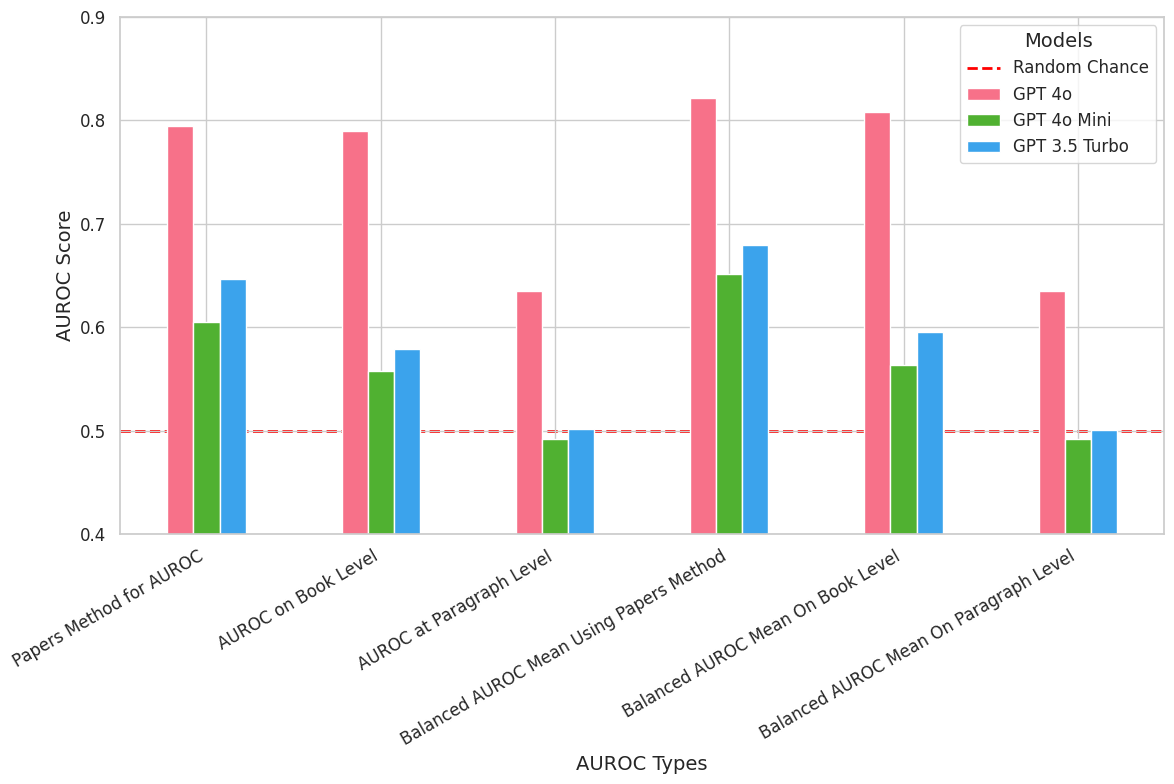

In [ ]:
# Filter the data for 'private' datasplit
df = auroc_results_on_year_published[auroc_results_on_year_published['datasplit'] == 'all'].dropna(
    subset=['auroc_book_level_binary', 'auroc_book_level', 'auroc_chunk_level', 'mean_auroc_book_level_binary', 'mean_auroc_book_level','mean_auroc_chunk_level']
)

# Define models and AUROC score variants
models = df['model']
auroc_book_level_binary = df['auroc_book_level_binary']
auroc_book_level = df['auroc_book_level']
auroc_chunk_level = df['auroc_chunk_level']
mean_auroc_book_level_binary = df['mean_auroc_book_level_binary']
mean_auroc_book_level = df['mean_auroc_book_level']
mean_auroc_chunk_level = df['mean_auroc_chunk_level']

# Define the AUROC types and prepare the data for each model
auroc_types = ['Papers Method for AUROC', 'AUROC on Book Level', 'AUROC at Paragraph Level',
               'Balanced AUROC Mean Using Papers Method', 'Balanced AUROC Mean On Book Level','Balanced AUROC Mean On Paragraph Level']
auroc_data = [auroc_book_level_binary, auroc_book_level, auroc_chunk_level,
              mean_auroc_book_level_binary, mean_auroc_book_level,mean_auroc_chunk_level]

# # Check data consistency
# if not all(len(x) == len(models) for x in auroc_data):
#     print(x,models)
#     raise ValueError("One of the AUROC data lists has a different length than the number of models.")

# Number of models
n_models = len(models)
bar_width = 0.15

# Set a color palette and style for better aesthetics
sns.set(style="whitegrid")
colors = sns.color_palette("husl", n_colors=n_models)

# Plot the improved bar chart
plt.figure(figsize=(12, 8))
plt.ylim(0.4, 0.90)

for i, (model, color) in enumerate(zip(models, colors)):
    plt.bar(np.arange(len(auroc_types)) + i * bar_width,
            [auroc_data[j].iloc[i] for j in range(len(auroc_types))],  # Using .iloc[i] to ensure correct indexing
            bar_width, label=model, color=color)

# Add gridlines, improve font size, and make the chart more aesthetically pleasing
plt.xlabel('AUROC Types', fontsize=14)
plt.ylabel('AUROC Score', fontsize=14)
# plt.title('AUROC Score Comparison by Type for Different Models', fontsize=16)
plt.xticks(np.arange(len(auroc_types)) + (n_models - 1) * bar_width / 2,
           auroc_types, rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

plt.legend(title='Models', fontsize=12, title_fontsize=14)

# Show the plot with improved layout and readability
plt.tight_layout()
plt.savefig('images/auroc_results_on_year_published.png')
plt.show()


## Graph showing how models are getting better at telling real paragraphs from fakes even when not trained on.


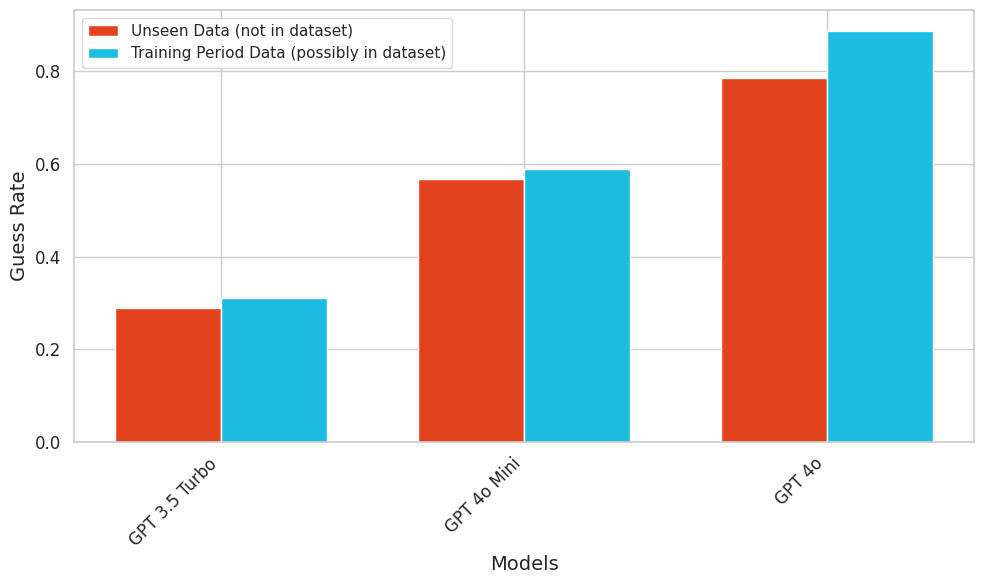

In [ ]:
models = df['model'][::-1]
suspected_guess_rate = df['consistant_suspected_guess_rate'][::-1]
baseline_guess_rate = df['consistant_baseline_guess_rate'][::-1]

# Define bar properties
bar_width = 0.35
index = np.arange(len(models))

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot baseline guess rate first and suspected guess rate second
plt.bar(index, baseline_guess_rate, bar_width, label='Unseen Data (not in dataset)', color='#E2421D')
plt.bar(index + bar_width, suspected_guess_rate, bar_width, label='Training Period Data (possibly in dataset)', color='#1DBDE2')

# Set plot labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Guess Rate', fontsize=14)
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

# Show the plot with the updated order
plt.tight_layout()
plt.savefig('images/consistant_guess_rate.png')
plt.show()


## Mean book level AUROC by model, split by availibility status



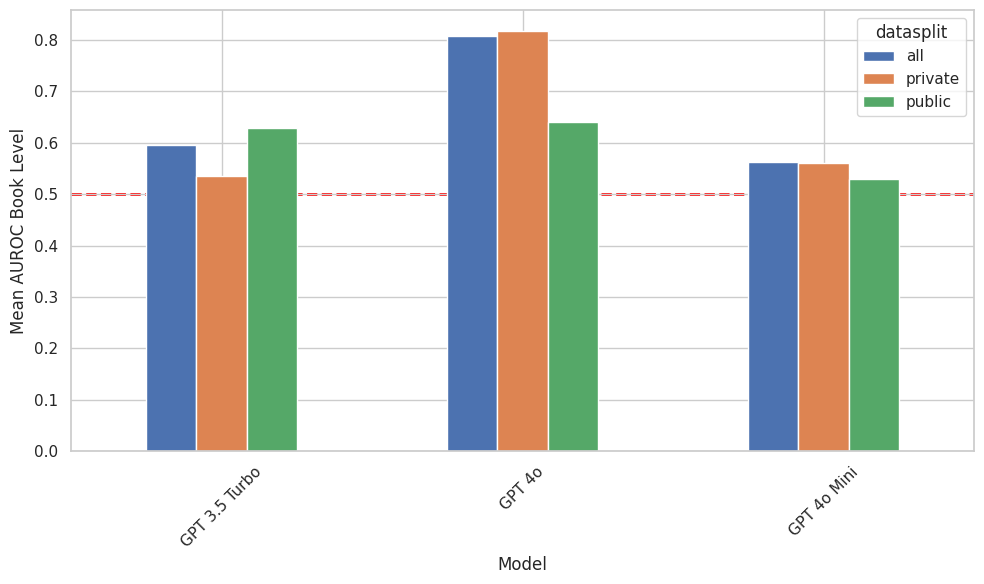

In [ ]:

df = auroc_results_on_year_published
# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'mean_auroc_book_level']]

# Create a pivot table to have datasplit on one axis and model on another, with auroc_book_level as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_auroc_book_level')


# Plot a grouped bar chart
df_pivot.plot(kind='bar', figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

# Set title and labels
# plt.title('Mean AUROC Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Mean AUROC Book Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## A simplified graph showing auroc_book_level by model, split by availibility status

<ipython-input-28-3781f45e0d91>:13: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='auroc_book_level')


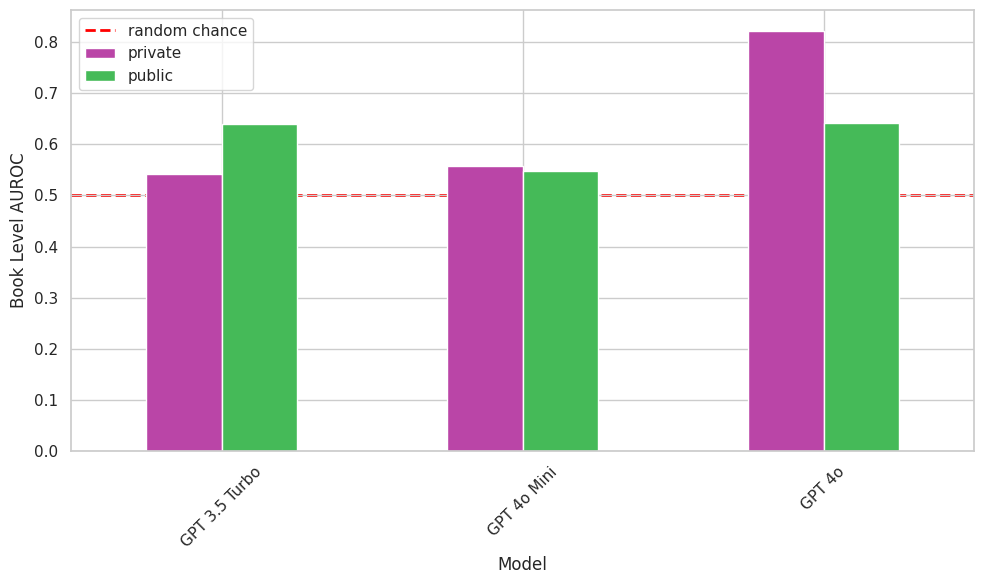

In [ ]:

df = auroc_results_on_year_published
# auroc_results_on_year_published['auroc_book_level_confidence_interval']

model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'auroc_book_level']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with auroc_book_level as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='auroc_book_level')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#BA45A7','#45BA58'], figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Book Level AUROC')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.yticks([i * 0.1 for i in range(9)])

plt.legend()
plt.tight_layout()
plt.savefig('images/auroc_book_level_by_model_simplified.png')

plt.show()

# auroc_results_on_year_published['auroc_book_level_confidence_interval']


## A graph showing how the guess rate changes based on availibility status (paragraph level)

<ipython-input-31-a942a676ed6f>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate')


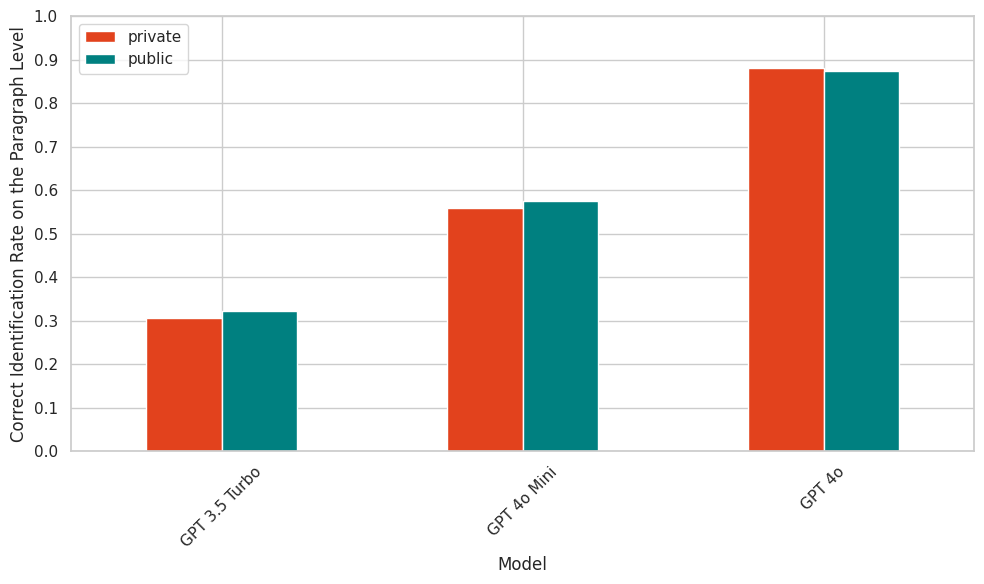

In [ ]:

df = auroc_results_on_year_published
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'suspected_guess_rate']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#E2421D','teal'], figsize=(10, 6))
# plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)
plt.yticks([i * 0.1 for i in range(11)])

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Correct Identification Rate on the Paragraph Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## A graph showing how the guess rate changes based on availibility status (book level)

<ipython-input-34-fff6da11f457>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate_book_level')


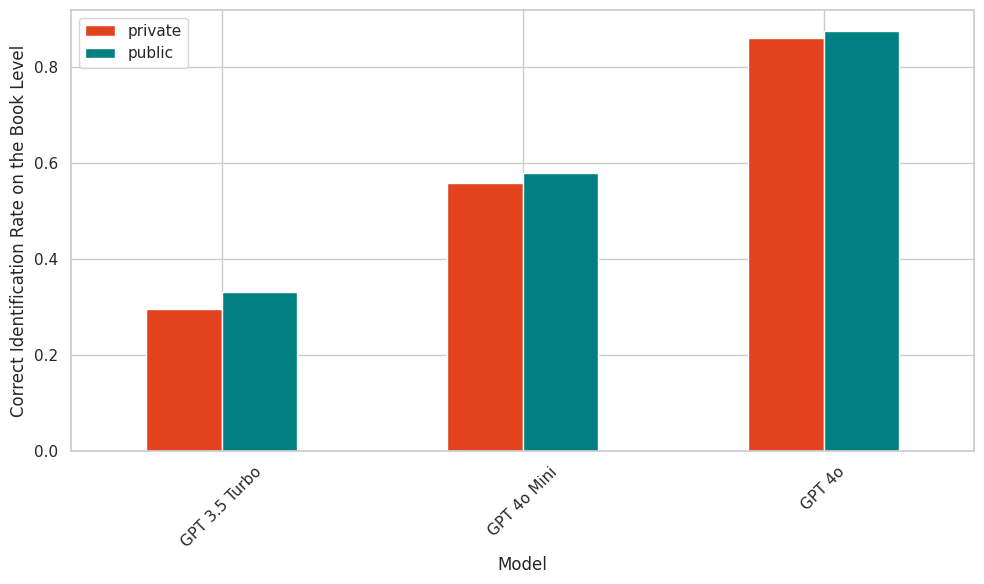

In [ ]:
df = auroc_results_on_year_published
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'suspected_guess_rate_book_level']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate_book_level')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#E2421D','teal'], figsize=(10, 6))
# plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Correct Identification Rate on the Book Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
